# HSE 2022: Mathematical Methods for Data Analysis

## Homework 2

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
import math
from math import sqrt
import random
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style="darkgrid")

### Data

For this homework we use Dataset from seaborn on diamonds prices.

In [3]:
data = sns.load_dataset('diamonds')

y = data.price
X = data.drop(['price'], axis=1)
columns = data.drop(['price'], axis=1).columns

## Linear regression

#### 0. [0.25 points] Encode categorical variables.

In [4]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [5]:
print(X.cut.unique())
print(X.color.unique())
print(X.clarity.unique())

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']
['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']


1) Cut

Значения категориальной переменной являются порядковыми: Very good лучше, чем Good => используем Label Encoding

2) Color

Значения категориальной переменной являются порядковыми: J - худший, D - лучший => Label Encoding

3) Clarity

=> One Hot Encoding


In [6]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
X.color = encoder.fit_transform(X.color)
X.color.unique()

array([1, 5, 6, 4, 2, 3, 0])

In [7]:
X.cut = encoder.fit_transform(X.cut)
X.cut.unique()

array([2, 3, 1, 4, 0])

In [8]:
X = pd.get_dummies(data=X, columns=['clarity'], drop_first = True)
X.head()

,carat,cut,color,depth,table,x,y,z,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,2,1,61.5,55.0,3.95,3.98,2.43,0,0,0,0,0,1,0
1,0.21,3,1,59.8,61.0,3.89,3.84,2.31,0,0,0,0,1,0,0
2,0.23,1,1,56.9,65.0,4.05,4.07,2.31,0,0,1,0,0,0,0
3,0.29,3,5,62.4,58.0,4.20,4.23,2.63,0,0,0,1,0,0,0
4,0.31,1,6,63.3,58.0,4.34,4.35,2.75,0,0,0,0,0,1,0


#### 1. [0.25 points] Split the data into train and test sets with ratio 80:20 with random_state=17.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

#### 2. [1 point] Train models on train data using StatsModels library and apply it to the test set; use $RMSE$ and $R^2$ as the quality measure.

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.01$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.01$
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) with $\alpha = 0.01$, $l_{1}$_$ratio = 0.6$

Don't forget to scale the data before training the models with StandardScaler!

In [10]:
# Scale the data before training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add the constant term to the data
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

In [11]:
## Linear Regression
linear_regression = sm.OLS(y_train, X_train_scaled)
linear_regression = linear_regression.fit()
lr_pred = linear_regression.predict(X_test_scaled)

# RMSE
lr_rmse = mean_squared_error(y_test, lr_pred, squared = False)
#R2
lr_r2 = r2_score(y_test, lr_pred)
print(f'Linear Regression: RMSE {lr_rmse} R2:{lr_r2}')

Linear Regression: RMSE 1178.9960913215941 R2:0.9141617585330128


In [12]:
## Ridge Regression
ridge_regression = sm.OLS(y_train, X_train_scaled)
ridge_results_fu = ridge_regression.fit()
ridge_results_fr = ridge_regression.fit_regularized(L1_wt=0, alpha=0.01, start_params=ridge_results_fu.params)
    
ridge_results = OLSResults(model=ridge_regression, 
                                             params=ridge_results_fr.params, 
                                             normalized_cov_params=ridge_regression.normalized_cov_params)
r_pred = ridge_results.predict(X_test_scaled)

# RMSE
r_rmse = mean_squared_error(y_test, r_pred, squared = False)
#R2
r_r2 = r2_score(y_test, r_pred)
print(f'Ridge Regression: RMSE {r_rmse} R2:{r_r2}')

Ridge Regression: RMSE 1191.7519796009808 R2:0.9122942947243566


In [13]:
## Lasso Regression
lasso_regression = sm.OLS(y_train, X_train_scaled)
lasso_results_fu = lasso_regression.fit()
lasso_results_fr = lasso_regression.fit_regularized(L1_wt=1, alpha=0.01, start_params=lasso_results_fu.params)
    
lasso_results = OLSResults(model=lasso_regression, 
                                             params=lasso_results_fr.params, 
                                             normalized_cov_params=lasso_regression.normalized_cov_params)
l_pred = lasso_results.predict(X_test_scaled)

# RMSE
l_rmse = mean_squared_error(y_test, l_pred, squared = False)
#R2
l_r2 = r2_score(y_test, l_pred)
print(f'Lasso Regression: RMSE {l_rmse} R2:{l_r2}')

Lasso Regression: RMSE 1178.9915936859898 R2:0.9141624134434022


In [14]:
## Elastic Net Regression
elastic_net_regression = sm.OLS(y_train, X_train_scaled)
elastic_net_results_fu = elastic_net_regression.fit()
elastic_net_results_fr = elastic_net_regression.fit_regularized(method='elastic_net', 
                                                        L1_wt= 0.6, 
                                                        alpha=0.01, 
                                                        start_params=elastic_net_results_fu.params)
     
elastic_net_results = OLSResults(model=elastic_net_regression, 
                                    params=elastic_net_results_fr.params, 
                                    normalized_cov_params=elastic_net_regression.normalized_cov_params)
en_pred = elastic_net_results.predict(X_test_scaled)

# RMSE
en_rmse = mean_squared_error(y_test, en_pred, squared = False)
#R2
en_r2 = r2_score(y_test, en_pred)
print(f'Elastic Net Regression: RMSE {en_rmse} R2:{en_r2}')

Elastic Net Regression: RMSE 1178.3400414740106 R2:0.9142572609654591


#### 3. [1 point] Explore the values of the parameters of the resulting models and compare the number of zero weights in them. Comment on the significance of the coefficients, overal model significance and other related factors from the results table

In [15]:
print('Linear Regression\n')
print(linear_regression.summary())
print('\n******************************************\n')

print('Ridge Regression\n')
print(ridge_results.summary())
print('\n******************************************\n')

print('Lasso Regression\n')
print(lasso_results.summary())
print('\n******************************************\n')

print('Elastic Net Regression\n')
print(elastic_net_results.summary())

Linear Regression

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.147e+04
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:18:34   Log-Likelihood:            -3.6542e+05
No. Observations:               43152   AIC:                         7.309e+05
Df Residuals:                   43136   BIC:                         7.310e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3928.6813      5.546 

**Make conclusions**

R2 for all models is about the same

At the significance level of the model 0, all models are significant (their Prob = 0)

x7 and x8 in all models have the value closest to 0, their P-value is the highest => they have the least impact on the result

#### 4. [1 point] Implement one of the elimination algorithms that were described in the Seminar_4 (Elimination by P-value, Forward elimination, Backward elimination), make conclusions.

In [35]:
# Elimination by P-value on the simple linear regression model
# Def for convenient column deletion
def eliminationByPValue(values):
    reg = sm.OLS(y_train, X_train_scaled[:, values] ).fit()
    reg_pred = reg.predict(X_test_scaled[:, values])
    print(reg.summary2())


# All features
eliminationByPValue([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.916      
Dependent Variable: price            AIC:                730863.7495
Date:               2022-10-16 15:02 BIC:                731002.5093
No. Observations:   43152            Log-Likelihood:     -3.6542e+05
Df Model:           15               F-statistic:        3.147e+04  
Df Residuals:       43136            Prob (F-statistic): 0.00       
R-squared:          0.916            Scale:              1.3274e+06 
---------------------------------------------------------------------
         Coef.     Std.Err.     t      P>|t|     [0.025      0.975]  
---------------------------------------------------------------------
const   3928.6813    5.5462  708.3543  0.0000   3917.8106   3939.5520
x1      5310.4649   26.7360  198.6260  0.0000   5258.0618   5362.8680
x2        56.2076    5.7123    9.8398  0.0000     45.0113     67.4038
x3      -551.4766    5.8902  -93.6269  0.0000  

In [37]:
# x7 has the highest P-value
eliminationByPValue([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.916      
Dependent Variable: price            AIC:                730861.8280
Date:               2022-10-16 15:03 BIC:                730991.9152
No. Observations:   43152            Log-Likelihood:     -3.6542e+05
Df Model:           14               F-statistic:        3.371e+04  
Df Residuals:       43137            Prob (F-statistic): 0.00       
R-squared:          0.916            Scale:              1.3273e+06 
---------------------------------------------------------------------
         Coef.     Std.Err.     t      P>|t|     [0.025      0.975]  
---------------------------------------------------------------------
const   3928.6813    5.5462  708.3619  0.0000   3917.8107   3939.5518
x1      5310.7614   26.7147  198.7952  0.0000   5258.4000   5363.1228
x2        56.2421    5.7109    9.8482  0.0000     45.0486     67.4355
x3      -551.4801    5.8901  -93.6287  0.0000  

In [38]:
# x8 in first model has the highest P-value
eliminationByPValue([0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.916      
Dependent Variable: price            AIC:                730863.2946
Date:               2022-10-16 15:03 BIC:                730984.7094
No. Observations:   43152            Log-Likelihood:     -3.6542e+05
Df Model:           13               F-statistic:        3.631e+04  
Df Residuals:       43138            Prob (F-statistic): 0.00       
R-squared:          0.916            Scale:              1.3274e+06 
---------------------------------------------------------------------
         Coef.     Std.Err.     t      P>|t|     [0.025      0.975]  
---------------------------------------------------------------------
const   3928.6813    5.5463  708.3416  0.0000   3917.8104   3939.5522
x1      5310.1223   26.7133  198.7820  0.0000   5257.7638   5362.4809
x2        56.0450    5.7101    9.8151  0.0000     44.8531     67.2369
x3      -551.4050    5.8901  -93.6155  0.0000  

**Make conclusions**

R2 did not change from model to model, we will be guided by AIC (the smaller it is, the better)

After removing x7, it dropped a little => the model improved, after removing the second one, it almost returned to its previous value

Since the P-value of x7 is significantly greater than that of x8, they affect the model differently

The conducted research confirms that x7 is the sign with the least influence, it can be removed (y, the width of the diamond almost does not affect its price)

x8 still has an impact on the model (its P-value is only 0.0599, at the significance level of 6% it is already significant), it should not be removed (the depth of the diamond is important)




#### 5. [1 point] Find the best (in terms of RMSE) $\alpha$ for Lasso regression using cross-validation with 4 folds. You must select values from range $[10^{-4}, 10^{3}]$.

Best alpha = 1.0000


Text(0, 0.5, 'CV score')

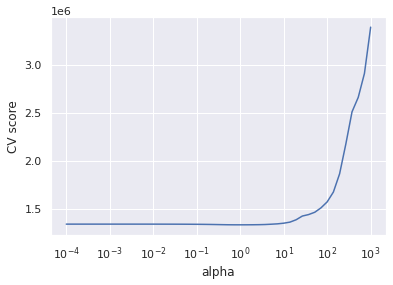

In [39]:
alphas = np.logspace(-4, 3)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_mean_squared_error", cv=4)
searcher.fit(X_train_scaled, y_train)

print("Best alpha = %.4f" % searcher.best_params_["alpha"])

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

## Gradient descent

#### 6. [3.5 points] Implement a Ridge regression model for the MSE loss function, trained by gradient descent.

All calculations must be vectorized, and python loops can only be used for gradient descent iterations. As a stop criterion, you must use (simultaneously):

* checking for the Absolute-value norm of the weight difference on two adjacent iterations (for example, less than some small number of the order of $10^{-6}$, set by the `tolerance` parameter);
* reaching the maximum number of iterations (for example, 10000, set by the `max_iter` parameter).

You need to implement:

* Full gradient descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Stochastic Gradient Descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ is the estimate of the gradient over the batch of objects selected randomly.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$

* Adagrad method:

$$
G_0 = 0, \\
G_{k + 1} = G_{k} + (\nabla_{w} Q(w_{k+1}))^2, \\
w_{k + 1} = w_{k} - \eta * \frac{\nabla_{w} Q(w_{k+1})}{\sqrt{G_{k+1} + \epsilon}}.
$$



To make sure that the optimization process really converges, we will use the `loss_history` class attribute. After calling the `fit` method, it should contain the values of the loss function for all iterations, starting from the first one (before the first step on the anti-gradient).

You need to initialize the weights with a random vector from normal distribution. The following is a template class that needs to contain the code implementing all variations of the models.

In [93]:
from sklearn.base import BaseEstimator

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3,
                 reg_cf=0.01, epsilon=0.001):
        """
        gd_type: str
            'GradientDescent', 'StochasticDescent', 'Momentum', 'Adagrad'
        delta: float
            proportion of object in a batch (for stochastic GD)
        tolerance: float
            for stopping gradient descent
        max_iter: int
            maximum number of steps in gradient descent
        w0: np.array of shape (d)
            init weights
        eta: float
            learning rate
        alpha: float
            momentum coefficient
        reg_cf: float
            regularization coefficient
        epsilon: float
            numerical stability
        """ 
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w_prev = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.reg_cf = reg_cf
        self.epsilon = epsilon
        self.h = 0
        self.G = 0
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        y = np.array(y)
        self.w = np.random.normal(0, 1, X.shape[1])
        if self.w_prev is None:
            self.w_prev = np.zeros(X.shape[1])
        
        for i in range(self.max_iter):
            if self.tolerance > np.linalg.norm(self.w_prev - self.w):
                break
            self.w_prev = self.w
            if self.gd_type == 'GradientDescent':
                weight = self.full_gradient_descent(X, y)
            elif self.gd_type == 'StochasticDescent': 
                weight = self.stochastic_descent(X, y)
            elif self.gd_type == 'Momentum': 
                weight = self.momentum(X, y)
            elif self.gd_type == 'Adagrad': 
                weight = self.adagrad(X, y)
            else:
                raise Exception('WRONG TYPE')
            self.w = weight
            self.loss_history.append(self.calc_loss(X, y))        
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return X.dot(self.w.T)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        return 2 * np.dot(X.T, self.predict(X) - y) / X.shape[0] + 2 * np.dot(self.reg_cf, self.w)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return mean_squared_error(y, self.predict(X))

    def full_gradient_descent(self, X, y):
        return self.w - np.dot(self.eta, self.calc_gradient(X, y))
        
    def stochastic_descent(self, X, y):
        batch = np.random.randint(0, len(X), math.floor(self.delta * len(X)))
        batch_x = X[batch, :]
        batch_y = y[batch]
        return self.w - np.dot(self.eta, self.calc_gradient(batch_x, batch_y))
        
    def momentum(self, X, y):
        self.h = self.alpha * self.h + self.eta* self.calc_gradient(X, y)
        return self.w - self.h
    
    def adagrad(self, X, y):
        self.G = self.G + np.square(self.calc_gradient(X, y))
        return self.w - self.eta * self.calc_gradient(X, y) / np.sqrt(self.G + self.epsilon)

#### 7. [1 points] Train and validate "hand-written" models on the same data, and compare the quality with the Sklearn or StatsModels methods. Investigate the effect of the `max_iter` and `alpha` parameters on the optimization process. Is it consistent with your expectations?

In [94]:
# Sklearn VS LinReg (best model in the world! :)
sklearn_lin = sklearn.linear_model.LinearRegression()

weights = np.random.rand(X_train_scaled[0].size)
my_lin = LinReg(gd_type = 'GradientDescent', w0 = weights)

sklearn_lin = sklearn_lin.fit(X_train_scaled, y_train)
my_lin = my_lin.fit(X_train_scaled, y_train)

skl_pred = sklearn_lin.predict(X_test_scaled)
my_pred = my_lin.predict(X_test_scaled)

# RMSE
skl_rmse = mean_squared_error(y_test, skl_pred, squared=False)
my_rmse = mean_squared_error(y_test, my_pred, squared=False)
# R2
skl_r2 = r2_score(y_test, skl_pred)
my_r2 = r2_score(y_test, my_pred)

print(f'Linear Regression: RMSE {skl_rmse} R2:{skl_r2}')
print(f'My Regression: RMSE {my_rmse} R2:{my_r2}')

Linear Regression: RMSE 1178.9960913215937 R2:0.9141617585330128
My Regression: RMSE 1273.9274722261964 R2:0.89978205624191


**Mini Conclusions**

The RMSE of the sklearn model is slightly smaller than that of our model, the R2 is higher for sklearn => Sklearn won the battle this time, BUT
Our model is not completely terrible, as the results differ slightly))

In [64]:
searcher = GridSearchCV(LinReg(), [{"gd_type": ["Momentum"], "alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 1e1, 1e2]}], scoring = "neg_root_mean_squared_error", cv = 4)
searcher.fit(X_train_scaled, y_train)
best_alpha = searcher.best_params_["alpha"]
print(f'Alpha for Momentum: {best_alpha}')

grad_iters = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
searcher = GridSearchCV(LinReg(), [ {"gd_type": ["GradientDescent"], "max_iter": grad_iters}], scoring = "neg_root_mean_squared_error", cv = 4)
searcher.fit(X_train_scaled, y_train)
best_gd_iters = searcher.best_params_["max_iter"]
print(f'Full GD iterations: {best_gd_iters}')
print(grad_iters)

searcher = GridSearchCV(LinReg(), [ {"gd_type": ["StochasticDescent"], "max_iter": grad_iters, "delta": [0.3]}], scoring = "neg_root_mean_squared_error", cv = 4)
searcher.fit(X_train_scaled, y_train)
best_sgd_iters = searcher.best_params_["max_iter"]
print(f'SGD iterations: {best_sgd_iters}')

searcher = GridSearchCV(LinReg(), [{ "gd_type": ["Momentum"], "alpha": [best_alpha], "max_iter": grad_iters}], scoring = "neg_root_mean_squared_error", cv = 4)
searcher.fit(X_train_scaled, y_train)
best_m_iters = searcher.best_params_["max_iter"]
print(f'Momentum iterations = {best_m_iters}')

searcher = GridSearchCV(LinReg(), [{ "gd_type": ["Adagrad"], "alpha": [best_alpha], "max_iter": grad_iters}], scoring = "neg_root_mean_squared_error", cv = 4)
searcher.fit(X_train_scaled, y_train)
best_ad_iters = searcher.best_params_["max_iter"]
print(f'Adagrad iterations = {best_ad_iters}')

Alpha for Momentum: 0.1
Full GD iterations: 2500
[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
SGD iterations: 2500
Momentum iterations = 2500
Adagrad iterations = 2250


**Make conclusions**

The more iterations = the better

Best alpha = 0.1

#### 8. [1 points] Plot graphs (on the same picture) of the dependence of the loss function value on the iteration number for Full GD, SGD, Momentum and Adagrad. Draw conclusions about the rate of convergence of various modifications of gradient descent.

Don't forget about what *beautiful* graphics should look like!

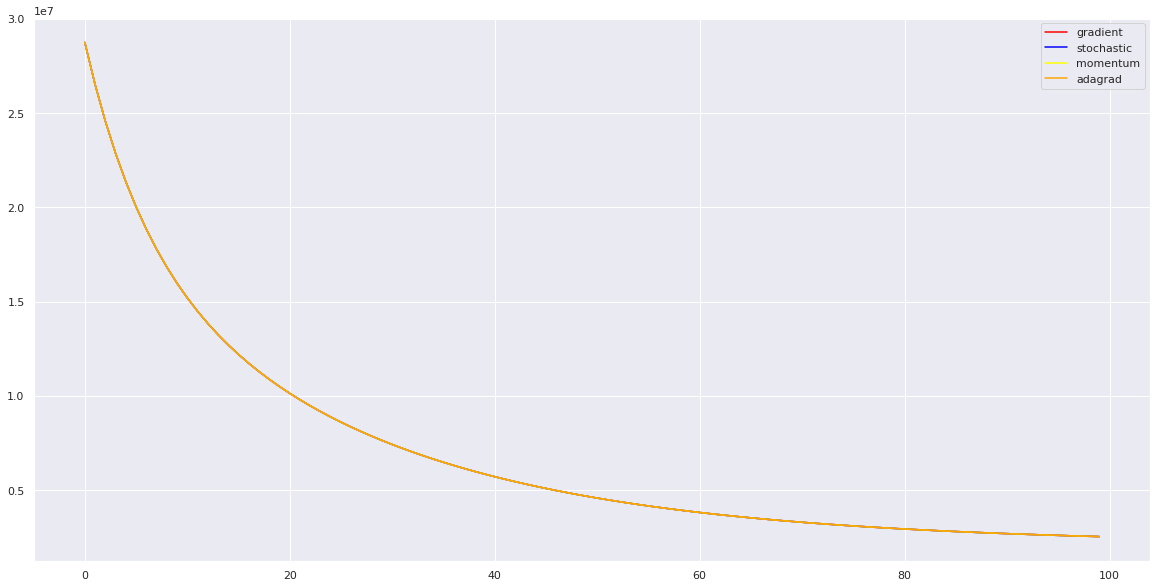

In [99]:
weights = np.random.rand(X_train_scaled[0].size)
gd = LinReg(gd_type = 'GradientDescent', w0 = weights, max_iter = best_gd_iters)
trained_gd = gd.fit(X_train_scaled, y_train)

sgd = LinReg(gd_type='StochasticDescent', w0 = weights, max_iter = best_sgd_iters, delta = 0.3)
trained_sgd = gd.fit(X_train_scaled, y_train)

momentum = LinReg(gd_type = 'Momentum', w0 = weights, max_iter = best_m_iters, alpha = best_alpha)
trained_momentum = gd.fit(X_train_scaled, y_train)

adagrad = LinReg(gd_type = 'Adagrad', w0 = weights, max_iter = best_ad_iters)
trained_adagrad = gd.fit(X_train_scaled, y_train)


plt.figure(figsize=(20, 10))
plt.plot(trained_gd.loss_history[:100], label='gradient', color = 'red')
plt.plot(trained_sgd.loss_history[:100], label='stochastic', color = 'blue')
plt.plot(trained_momentum.loss_history[:100], label = 'momentum', color = 'yellow')
plt.plot(trained_adagrad.loss_history[:100], label = 'adagrad', color = 'orange')
plt.legend()
plt.show()

**Make conclusions**

All methods lead to a ~fast decrease in the values of the loss function

And they behave about the same
